In [20]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import math
plt.rcParams.update({'font.size': 26})

In [21]:
def apply_white_noise(x, A, snr, random_seed):
    '''
    Random sampling from a normal distribution to generate white noise.
    '''
    np.random.seed(random_seed)
    stddev = A.mean() / snr / 4 # approximately noise levels that match snr
    noise = np.random.normal(0, stddev, len(x))
    return x + noise

def apply_pink_noise(x, A, snr, num_sources, random_seed):
    '''
    Stochastic Voss-McCartney algorithm for generating pink noise.

    References:
        https://github.com/AllenDowney/ThinkDSP/blob/master/code/voss.ipynb
        https://www.firstpr.com.au/dsp/pink-noise/
    '''
    np.random.seed(random_seed)
    nrows = len(x)
    ncols = num_sources

    noise = np.full((nrows, ncols), np.nan)
    noise[0, :] = np.random.random(ncols)
    noise[:, 0] = np.random.random(nrows)

    cols = np.random.geometric(0.5, nrows)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=nrows)
    noise[rows, cols] = np.random.random(nrows)

    noise = pd.DataFrame(noise)
    noise.fillna(method='ffill', axis=0, inplace=True)
    noise = noise.sum(axis=1).to_numpy()
    noise = (noise - noise.mean())
    noise = (A.mean()/snr) * noise / 2 # approximately noise levels that match snr
    return noise + x

def apply_drift(x, resolution, random_seed):
    np.random.seed(random_seed)
    def sigmoidal(y, m, w, b):
        return 1 / (1 + np.exp( - (y * w + b) )) * m
    y = np.linspace(-1, 1, 8192)
    drift = np.zeros(resolution, dtype='float32')
    n = 10
    for _ in range(n):
        h = np.random.uniform(-500, 500)  # changed (-1000, 1000)
        w = np.random.uniform(-20, 20)
        b = np.random.uniform(-20, 20)
        drift += sigmoidal(y, h, w, b) / n
    return x + drift

def compute_gaussian_peak(x, A, loc, scale, asymmetry=None, epsilon=1e-7):
    '''
    Computes a normal Gaussian (asymmetry == None)
               or
               modified Gaussian (asymmetry != None)
    '''
    if asymmetry is None:
        return A * np.exp((-(x - loc)**2) / (2 * scale**2))
    return A * np.exp(-1/2 * ((x - loc)/(epsilon + scale + asymmetry * (x - loc)))**2)


class Simulator:

    def __init__(self,
                 resolution,
                 num_peaks_range,
                 snr_range,
                 A_range,
                 loc_range,
                 scale_range,
                 asymmetry_range,
                 pink_noise_prob):

        self.x = np.linspace(0, 1, resolution)
        self.resolution = resolution
        self.num_peaks_range = num_peaks_range
        self.snr_range = snr_range
        self.A_range = A_range
        self.loc_range = loc_range
        self.scale_range = scale_range
        self.asymmetry_range = asymmetry_range
        self.pink_noise_prob = pink_noise_prob

    def run(self, random_seed):

        np.random.seed(random_seed)

        self.num_peaks = np.random.randint(*self.num_peaks_range)
        self.A = np.random.uniform(*self.A_range, size=(self.num_peaks,))
        self.loc = np.random.uniform(*self.loc_range, size=(self.num_peaks,))
        self.scale = np.random.uniform(*self.scale_range, size=(self.num_peaks,))
        if self.asymmetry_range is not None:
            self.asymmetry = np.random.uniform(*self.asymmetry_range, size=(self.num_peaks,))
        else:
            self.asymmetry = [None]*self.num_peaks

        chromatogram = np.zeros_like(self.x)
        for a, m, s, t in zip(self.A, self.loc, self.scale, self.asymmetry):
            chromatogram += compute_gaussian_peak(self.x, a, m, s, t)

        self.snr = np.random.uniform(*self.snr_range)


        if self.pink_noise_prob > np.random.random():
            chromatogram_noisy = apply_pink_noise(chromatogram, self.A, self.snr, 16, random_seed)
        else:
            chromatogram_noisy = apply_white_noise(chromatogram, self.A, self.snr, random_seed)

        chromatogram_noisy_drift = apply_drift(chromatogram_noisy, self.resolution, random_seed)

        return chromatogram_noisy, chromatogram_noisy_drift, chromatogram

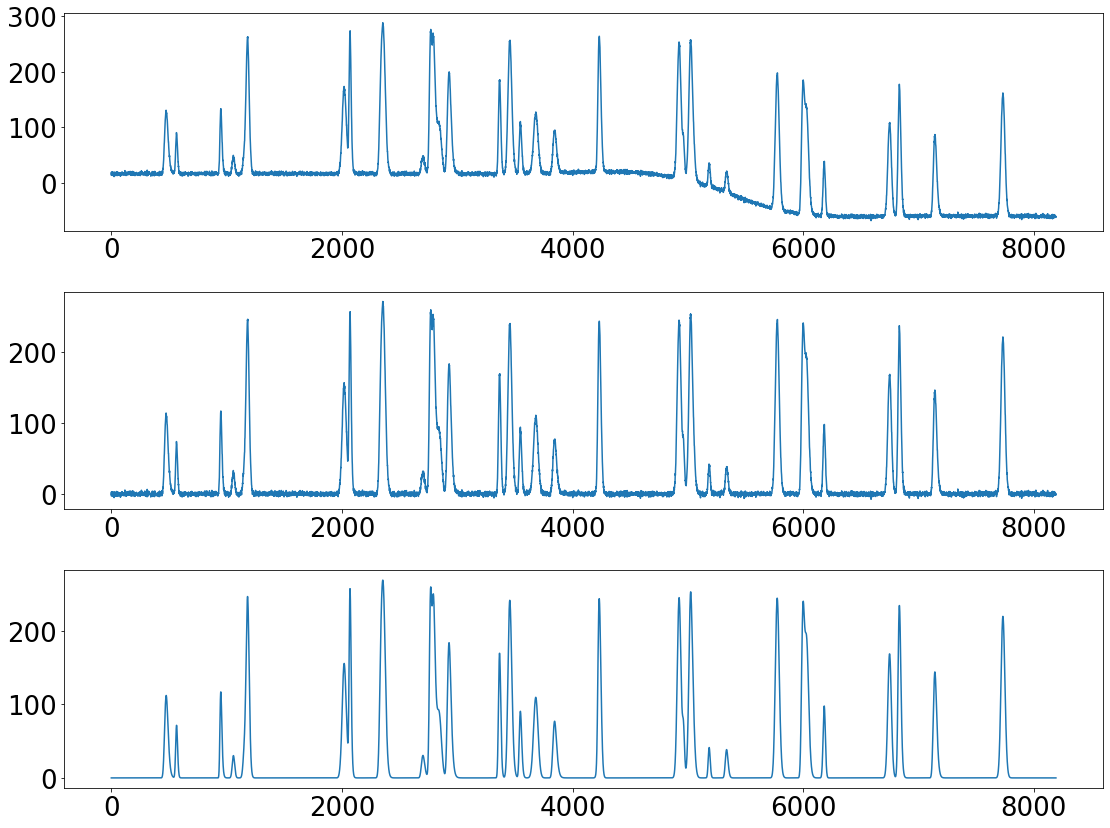

In [22]:
simulator = Simulator(
    resolution=8192,
    num_peaks_range=(1, 100), 
    snr_range=(2, 20),
    A_range=(25, 250),
    loc_range=(0.05, 0.95),
    scale_range=(0.001, 0.0025),
    asymmetry_range=(0.0, 0.1),
    pink_noise_prob=0,
)

x, y, z = simulator.run(30)
fig, ax = plt.subplots(3,1, figsize=(16, 12))


ax[0].plot(y)
ax[1].plot(x)
ax[2].plot(z)
#ax.set_ylim(-50, 50)
plt.tight_layout()

In [23]:
def apply_drift_(x, resolution):
    def sigmoidal(y, m, w, b):
        return 1 / (1 + np.exp( - (y * w + b) )) * m
    y = np.linspace(-1, 1, 8192)
    drift = np.zeros(resolution, dtype='float32')
    n = 10
    for _ in range(n):
        h = np.random.uniform(-500, 500)
        w = np.random.uniform(-20, 20)
        b = np.random.uniform(-20, 20)
        drift += sigmoidal(y, h, w, b) / n
    return x + drift

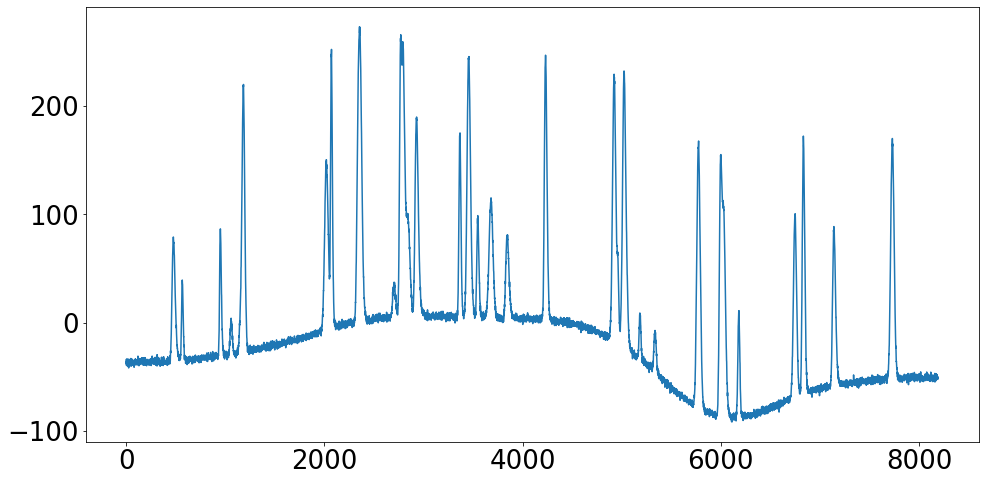

In [24]:
plt.figure(figsize=(16,8))
plt.plot(apply_drift_(y, 8192));

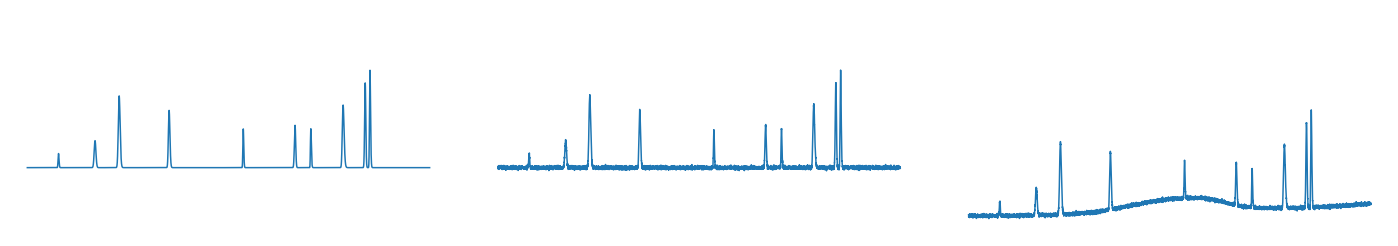

In [25]:
x, y, z = simulator.run(10)


fig, ax = plt.subplots(1, 3, figsize=(20, 4))

ax[0].plot(z)
ax[0].axis('off')
ax[0].set_ylim(-155, 350)
ax[1].plot(x)
ax[1].axis('off')
ax[1].set_ylim(-155, 350)
ax[2].plot(y)
ax[2].axis('off')
ax[2].set_ylim(-155, 350)

plt.tight_layout()

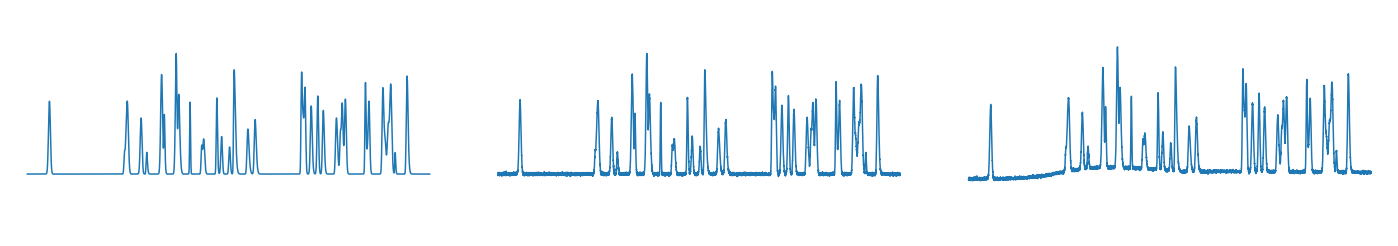

In [26]:
x, y, z = simulator.run(2)


fig, ax = plt.subplots(1, 3, figsize=(20, 4))

#for i, (ax, j) in enumerate(zip(axes.reshape(-1), [z,x,y])):
ax[0].plot(z)
ax[0].axis('off')
ax[0].set_ylim(-155, 400)
ax[1].plot(x)
ax[1].axis('off')
ax[1].set_ylim(-155, 400)
ax[2].plot(y)
ax[2].axis('off')
ax[2].set_ylim(-155, 400)
    
plt.tight_layout()

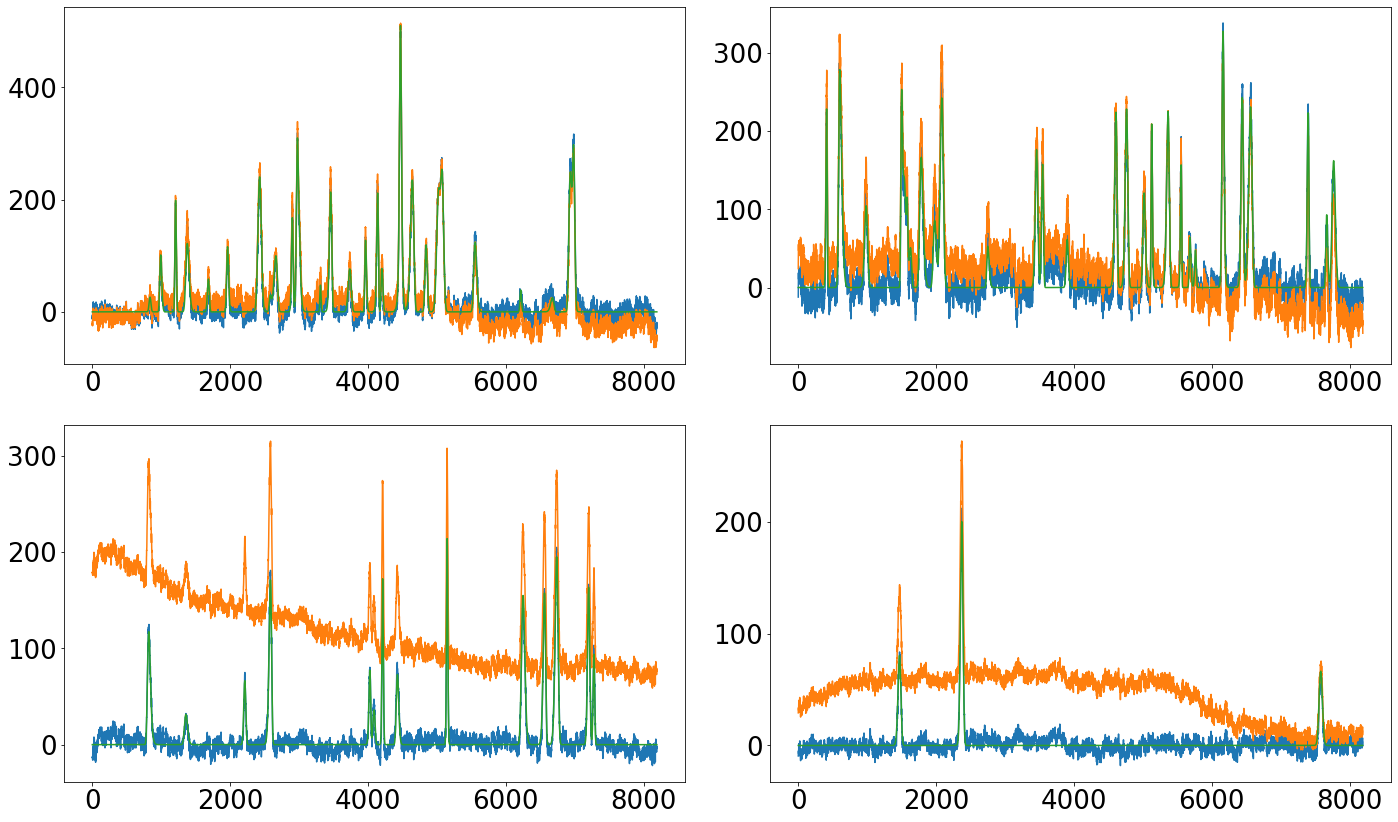

In [30]:
path = '../input/simulations/train/'

fig, axes = plt.subplots(2, 2, figsize=(20, 12))

for i, ax in enumerate(axes.reshape(-1)):
    x, y, z = np.load(path + f'chromatogram_{i}.npy')
    ax.plot(x)
    ax.plot(y)
    ax.plot(z)
    
plt.tight_layout()